In [2]:
import nltk
import spacy
import pandas
import tqdm, itertools
#nltk.download('punkt')

from IPython import display
sp = spacy.load('en', disable=['parser', 'ner'])
import html
import re

from sklearn.base import BaseEstimator

from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, recall_score, precision_score, fbeta_score

import seaborn as sbn
from matplotlib import pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from IPython import display

import numpy as np

In [2]:
html.unescape

<function html.unescape(s)>

In [3]:
with open('SMSSpamCollection.txt', 'rt', encoding='utf-8') as f:
    lines = [[html.unescape(y.strip()) for y in x.split('\t')] for x in f.readlines()]

In [4]:
lines[:10]

[['ham',
  'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'],
 ['ham', 'Ok lar... Joking wif u oni...'],
 ['spam',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
 ['ham', 'U dun say so early hor... U c already then say...'],
 ['ham', "Nah I don't think he goes to usf, he lives around here though"],
 ['spam',
  "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv"],
 ['ham',
  'Even my brother is not like to speak with me. They treat me like aids patent.'],
 ['ham',
  "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune"],
 ['spam',
  'WINNER!! As a valued network customer you have been selected to receivea £

In [8]:
#функция, делающая разные варианты предобработки текста

def get_words(
    stopwords=False, 
    bigrams=False, 
    stemming=False, 
    lemming=False, 
    alpha=False
):
    def get_words_inner(line):
        if lemming:
            words = [token.lemma_ for token in get_words.lemmer(line)]
        else:
            words = get_words.re_words.findall(line)#nltk.tokenize.word_tokenize(line)
        words = [
            w.lower()
            for w in words 
            if (any(c.isalpha() for c in w) if alpha else True)
            and (w.lower() not in get_words.stopwords if stopwords else True)
        ]
        if stemming:
            words = [get_words.stemmer.stem(word) for word in words]  
        if bigrams:
            words = list(nltk.bigrams(words))
        return words
    return get_words_inner
get_words.lemmer = spacy.load('en', disable=['parser', 'ner'])
get_words.stemmer = nltk.stem.snowball.SnowballStemmer('english')
get_words.stopwords = set(nltk.corpus.stopwords.words('english'))
get_words.re_words = re.compile(
    r'(?:[a-zA-Z]+)|(?:\d|\.|,)*(?:\d)+|(?=\W+)(?=\S+).+?(?=\s|\w|$)'
)

In [1]:
class Classifier(BaseEstimator):
    def __init__(self, return_cat=False):
        self.return_cat = return_cat
        self.model = None
        
    def count_words(self, vector):
        counter = {}
        for i, w in zip(vector.indices, vector.data):
            if i in counter:
                counter[i] += w
            else:
                counter[i]  = w
        return counter

    def add_counters(self, c1, c2):
        res = {}
        for k, v in c1.items():
            res[k] = v
        for k, v in c2.items():
            if k in res:
                res[k] += v
            else:
                res[k]  = v
        return res

    def add_counters_inplace(self, c1, c2):
        for k, v in c2.items():
            if k in c1:
                c1[k] += v
            else:
                c1[k] = v
    def total_counts(self, lines):
        counters = {
                'ham' : {},
                'spam': {}
                }
        sizes = {
                'ham' : 0.,
                'spam': 0.
                }
        for kind, line in lines:
            #counters[kind] = add_counters(counters[kind], count_words(line))
            self.add_counters_inplace(counters[kind], self.count_words(line))
            sizes[kind] += 1

        for kind, counter in counters.items():
            size = sizes[kind]
            for word in counter:
                counter[word] /= size
        return counters, sizes

    def fit(self, X, y):
        self.model = self.total_counts(zip(y, X))
    
    def guess(self, line, model):
        counters, sizes = model
        p_ham  = sizes['ham']
        p_spam = sizes['spam']
        eps = 1e-5
        for i,w in zip(line.indices, line.data):
            p_in_ham  = w*counters['ham' ][i] if i in counters['ham' ] else eps
            p_in_spam = w*counters['spam'][i] if i in counters['spam'] else eps
            p_sum = p_in_ham + p_in_spam
            p_ham  *= p_in_ham / p_sum
            p_spam *= p_in_spam / p_sum
    #    if p_ham+p_spam == 0:
    #        print(line)
        return p_ham / (p_ham + p_spam) if p_ham+p_spam > 0.0 else 0.5
    
    def predict(self, X):
        if self.model is None:
            raise 'wasn\'t fit'
        if self.return_cat:
            r = ['ham' if self.guess(x, self.model) > 0.5 else 'spam' for x in X]
        else:
            r = [self.guess(x, self.model) for x in X]
        return np.array(r)
    def decision_function(self, X):
        if self.model is None:
            raise 'wasn\'t fit'
        r = np.array([self.guess(x, self.model) for x in X])
        return r
    

NameError: name 'BaseEstimator' is not defined

In [9]:
# проверка, как работает предобработка
from ipywidgets import interact
@interact
def q(
    st=False, bi=False, stem=False, 
    lemm=False, alpha=False, 
    k=(0,100,1)
):
    
    f = get_words(st, bi, stem, lemm, alpha)
    print('|'.join(f(lines[k][1])if not bi else (' '.join(x) for x in f(lines[k][1]))))

interactive(children=(Checkbox(value=False, description='st'), Checkbox(value=False, description='bi'), Checkb…

# таблица примера предобработок

In [11]:
@interact
def q(k=(0,100,1)):
    pars = (
        'stopwords','stemming','lemming','alpha','bigrams'
    )
#     k = 50
    res = {}
    m = 0
    for i in range(6):
        params = {} if i==0 else {pars[i-1]:True}
        f = get_words(**params)
        w = f(lines[k][1])if i != 5 else [' '.join(x) for x in f(lines[k][1])]
        res[i] = w
        if len(w) > m:
            m = len(w)
    for k in res:
        if len(res[k]) < m:
            n = len(res[k])
            res[k] = res[k] + ['']*(m-n)
    for i in range(m):
        l = ' & '.join(v[i] for v in res.values()) + '\\\\'
        print(l)

interactive(children=(IntSlider(value=50, description='k'), Output()), _dom_classes=('widget-interact',))

# вычисление

In [6]:
def add_dicts(a, b):
    t = {}
    t.update(a)
    t.update(b)
    return t

In [7]:
# оценка работы разных методов предобработки с MultinomialNB

scoring = {
    'accuracy': 'accuracy', 
    'recall': make_scorer(recall_score, pos_label='ham'),
    'precision': make_scorer(precision_score, pos_label='ham'),
    'roc_auc': 'roc_auc',
    'corecall': make_scorer(recall_score, pos_label='spam'),
    'fbeta1': make_scorer(fbeta_score, pos_label='ham', beta=1),
    'fbeta10': make_scorer(fbeta_score, pos_label='ham', beta=10),
    'fbeta100': make_scorer(fbeta_score, pos_label='ham', beta=100)
}
relational_assessment = pandas.DataFrame(
    columns=['stop', 'stem', 'lemm', 'alpha', 'bigram', 'tfidf', 'num']+\
        ['res_{}'.format(metric) for metric in scoring.keys()]
)

for i_params, (st, stem, lemm, alpha, bigram, tfidf) in tqdm.tqdm(
    (enumerate(itertools.product(
        (False, True),
        (False, True),
        (False, True),
        (False, True),
        (False, True),
        (False, True)
    ))),
    total=2**6
):
        k = 0
        classifier = MultinomialNB()#LogisticRegression()#
        filter_f = get_words(st, bigram, stem, lemm, alpha)
        vectorizer = TfidfVectorizer(analyzer=filter_f)\
            if tfidf\
            else CountVectorizer(analyzer=filter_f)
        try:
            X = vectorizer.fit_transform([
                l[1]
                for l in lines
            ])
            y = [l[0] for l in lines]
            metrics = cross_validate(
                classifier,
                X,
                y,
                scoring=scoring,
                cv=RepeatedStratifiedKFold(10, 5),
#                 return_estimator=True
            )
            res = {
                score: sum(metrics[name])/len(metrics[name])
                for score, name in [
                    (score, 'test_{}'.format(score)) 
                    for score in scoring.keys()
                ]
            }
        except:
            print('error at {}: {}'.format(i_params, (st, stem, lemm, alpha, tfidf, k)))
            continue
        n_records = len(next(iter(metrics.values())))
        relational_assessment=relational_assessment.append(
            [
                add_dicts(
                    {
                        'stop':st,
                        'bigram': bigram,
                        'stem': stem,
                        'lemm': lemm,
                        'alpha': alpha,
                        'tfidf': tfidf,
                        'k': k,
                        'num': i_params,
                        'cls': metrics['estimator'][i]
                    },{
                        'res_{}'.format(metric):metrics['test_{}'.format(metric)][i]
                        for metric in scoring.keys()
                    }
                )
                for i in range(n_records)
            ],
            ignore_index=True
        )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [17:47<00:00, 16.68s/it]


In [6]:
relational_assessment = pandas.read_json(
    'relational_assessment(logistic).json'
)
relational_assessment

,stop,stem,lemm,alpha,bigram,tfidf,num,res_accuracy,res_recall,res_precision,res_roc_auc,res_corecall,res_fbeta1,res_fbeta10,res_fbeta100,k
0,False,False,False,False,False,False,0,0.989247,0.997930,0.989733,0.997654,0.933333,0.993814,0.997848,0.997929,0
1,False,False,False,False,False,False,0,0.989247,1.000000,0.987730,0.998482,0.920000,0.993827,0.999877,0.999999,0
2,False,False,False,False,False,False,0,0.994624,1.000000,0.993827,0.992215,0.960000,0.996904,0.999939,0.999999,0
3,False,False,False,False,False,False,0,0.985663,0.995859,0.987680,0.990090,0.920000,0.991753,0.995778,0.995858,0
4,False,False,False,False,False,False,0,0.989228,1.000000,0.987730,0.984360,0.918919,0.993827,0.999877,0.999999,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3195,True,True,True,True,True,True,63,0.903052,1.000000,0.899441,0.956830,0.270270,0.947059,0.998894,0.999989,0
3196,True,True,True,True,True,True,63,0.899461,1.000000,0.896104,0.960187,0.243243,0.945205,0.998853,0.999988,0
3197,True,True,True,True,True,True,63,0.910233,1.000000,0.906015,0.949350,0.333333,0.950690,0.998974,0.999990,0
3198,True,True,True,True,True,True,63,0.894075,1.000000,0.890943,0.959640,0.213333,0.942326,0.998790,0.999988,0


In [65]:
relational_assessment.to_json(
    'relational_assessment(logistic).json'
)

# графики

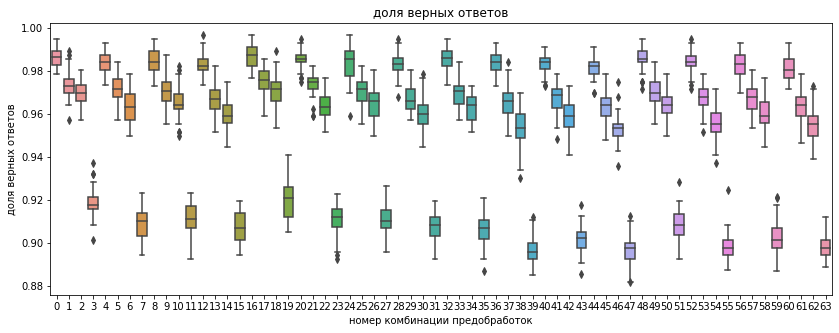

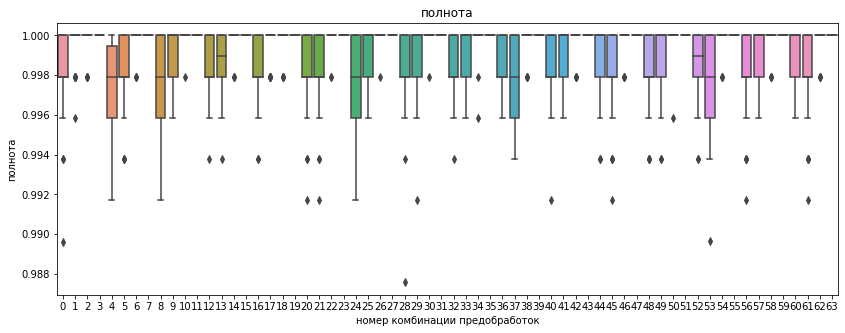

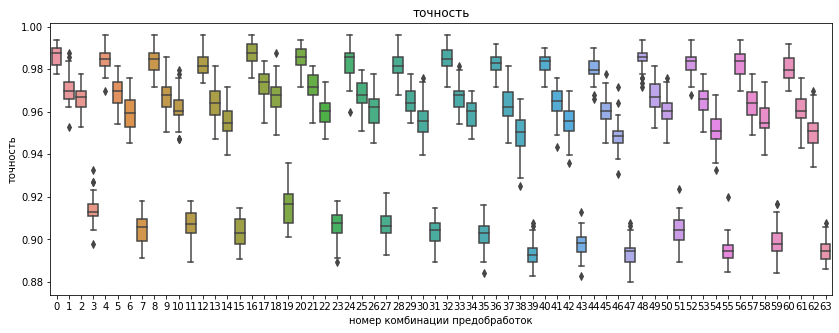

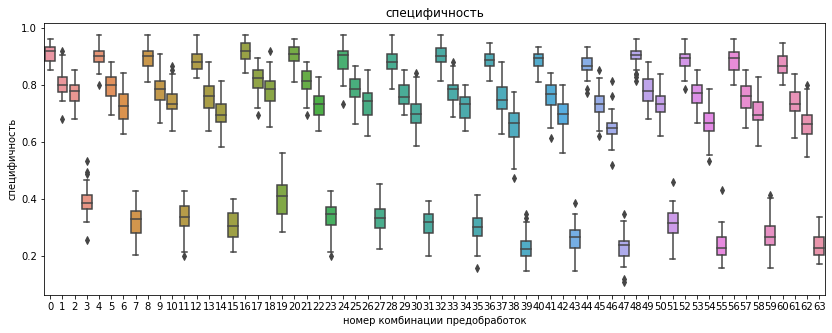

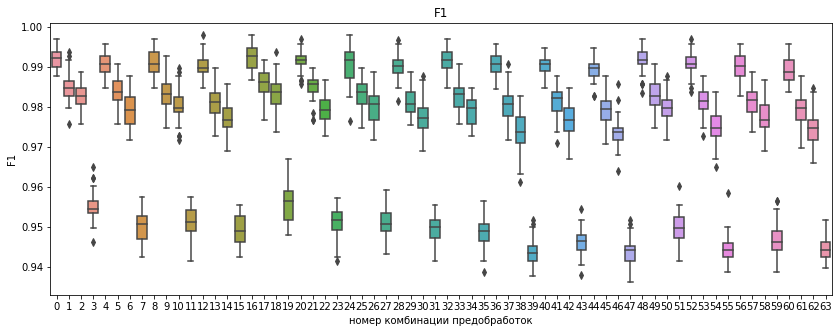

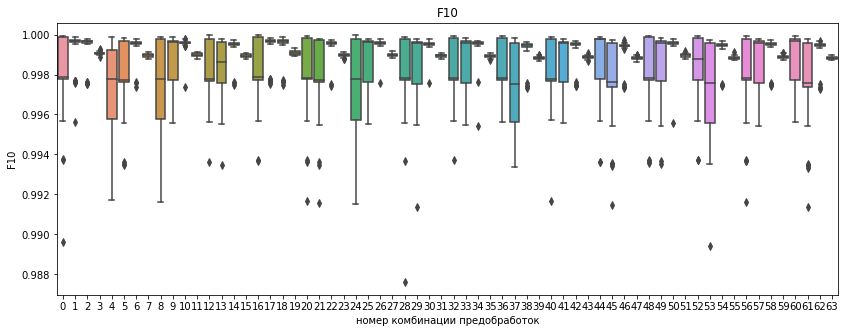

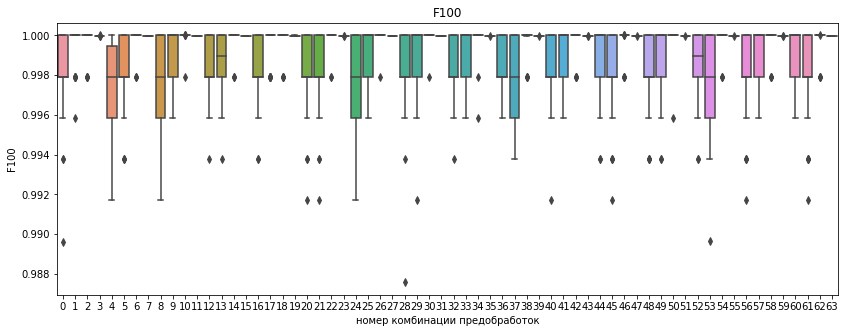

In [8]:
metrics = ('accuracy', 'recall', 'precision', 'corecall', 'fbeta1', 'fbeta10', 'fbeta100')
rmetrics = ('доля верных ответов', 'полнота', 'точность', 'специфичность', 'F1', 'F10', 'F100')
data = relational_assessment.copy()
num = 'номер комбинации предобработок'
data[num] = data['num']
for i, m in enumerate(metrics):
    #plt.subplot(len(metrics), 1, i+1)
    data[rmetrics[i]] = data['res_{}'.format(m)]
    plt.figure(figsize=(14,5))
    sbn.boxplot(
        x=num, y=rmetrics[i], 
        data=data,
        orient='v'
#         notch=True
#         bootstrap=1000
    )
#     sbn.swarmplot(
#         x=num, y=rmetrics[i], color='k',
#         data=data,
#         orient='v'
#     )
    plt.title(rmetrics[i])
    #display.display(plt.gcf())
    plt.savefig("64plot_rep_{}.pdf".format(m))

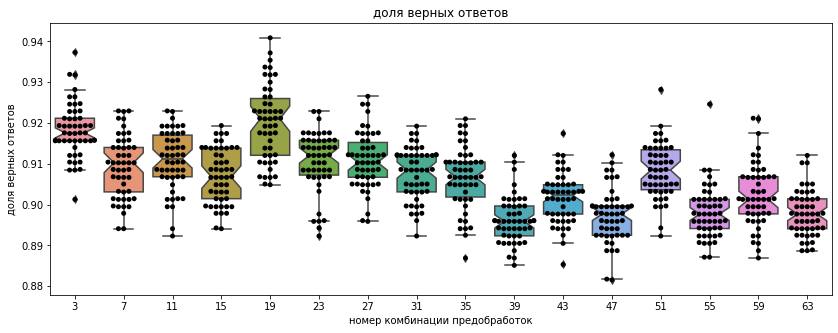

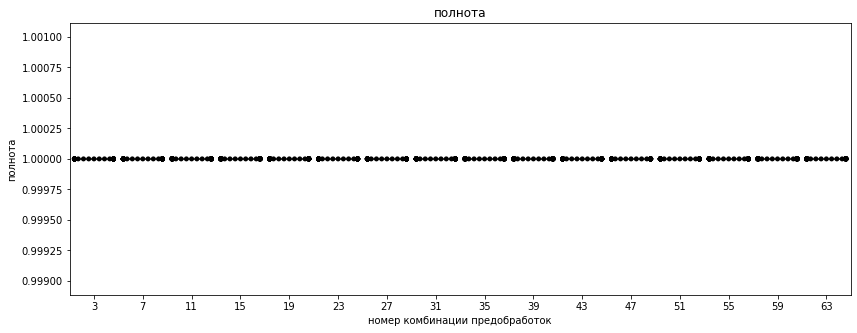

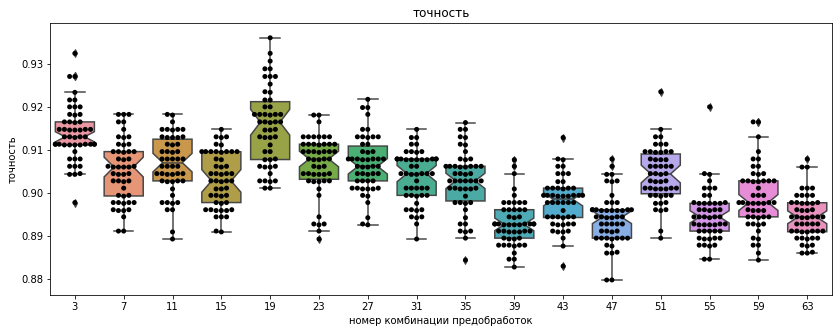

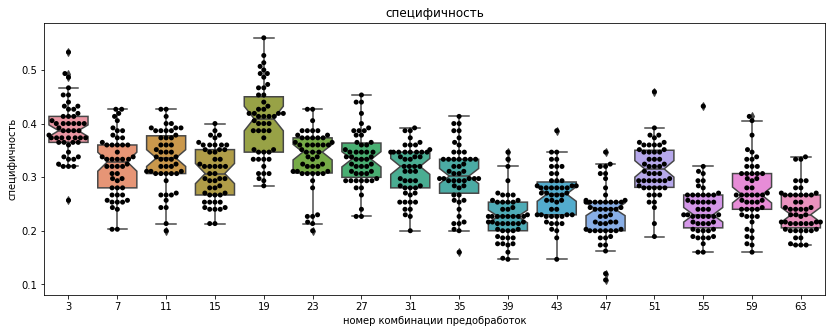

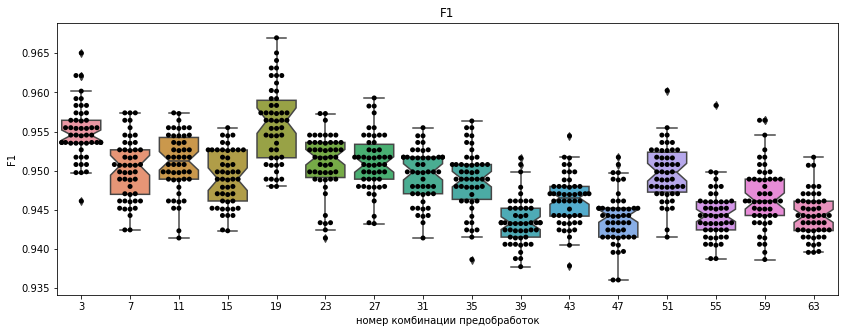

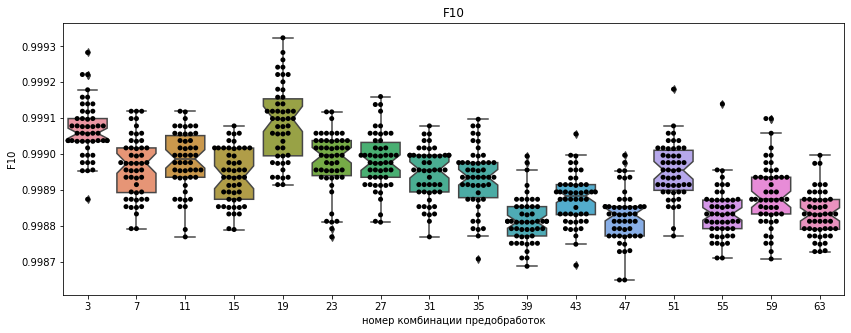

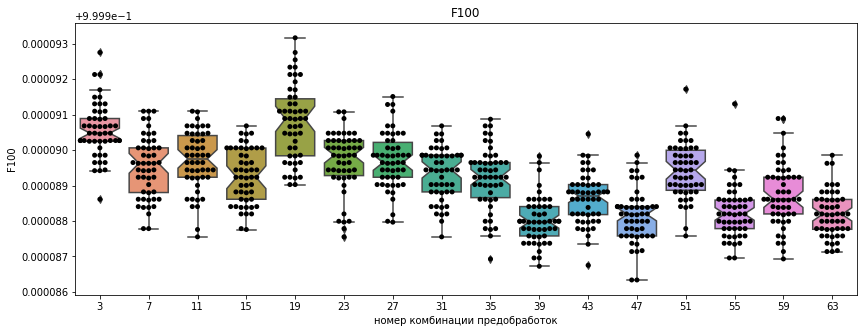

In [40]:
metrics = ('accuracy', 'recall', 'precision', 'corecall', 'fbeta1', 'fbeta10', 'fbeta100')
rmetrics = ('доля верных ответов', 'полнота', 'точность', 'специфичность', 'F1', 'F10', 'F100')
data = relational_assessment[
    (relational_assessment['tfidf']==True)
    ч& (relational_assessment['bigram']==True)
].copy()
num = 'номер комбинации предобработок'
data[num] = data['num']
for i, m in enumerate(metrics):
    plt.figure(figsize=(14,5))
    #plt.subplot(len(metrics), 1, i+1)
    data[rmetrics[i]] = data['res_{}'.format(m)]
    sbn.boxplot(
        x=num, y=rmetrics[i], 
        data=data,
        orient='v',
        notch=True
    )
    sbn.swarmplot(
        x=num, y=rmetrics[i], color='k',
        data=data,
        orient='v'
    )
    plt.title(rmetrics[i])
    #display.display(plt.gcf())
    plt.savefig("64plot_tfidf_rep_{}.svg".format(m))